In [1]:
# ===================================================================
# === SCRIPT 1: FEATURE ENGINEERING FOR REGRESSION ================
# ===================================================================

# === Imports ===
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, dayofweek
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

# === Step 1: Create Spark Session ===
spark = SparkSession.builder.appName("FlightPulse-Regression-Prep").getOrCreate()
print("--- SparkSession Created ---")


# === Step 2: Load and Prepare Base DataFrame ===
df = spark.read.csv("flights.csv", header=True, inferSchema=True)
df_transformed = df.withColumn(
    "flight_date_formatted", 
    to_date(col("FLIGHT_DATE"), "dd-MM-yyyy")
).withColumn(
    "day_of_week",
    dayofweek(col("flight_date_formatted"))
)
print("--- Base DataFrame Prepared ---")


# === Step 3: Feature Engineering for Passenger Prediction ===

# Our 'label' is the value we want to predict. In this case, it's the total passengers.
df_with_label = df_transformed.withColumn(
    "label", 
    col("TIER1_ELIGIBLE_PAX") + col("TIER2_ELIGIBLE_PAX") + col("TIER3_ELIGIBLE_PAX")
)

# We'll also calculate TotalSeats as a potential feature.
df_with_label = df_with_label.withColumn(
    "TotalSeats", 
    col("FIRST_CLASS_SEATS") + col("BUSINESS_CLASS_SEATS") + col("ECONOMY_SEATS")
)

# These are the columns we'll use to make our prediction.
categorical_cols = ["TIME_OF_DAY", "HAUL", "AIRCRAFT_TYPE"]
numerical_cols = ["day_of_week", "TotalSeats"]

# Create a list of StringIndexer stages for each categorical column
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep") for c in categorical_cols]

# Assemble all the indexed and numerical features into a single 'features' vector
assembler_inputs = [f"{c}_index" for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# The full pipeline will prepare the features
pipeline = Pipeline(stages=indexers + [assembler])

# Fit and transform the data
ml_ready_data = pipeline.fit(df_with_label).transform(df_with_label)

print("\n--- Feature Engineering Complete ---")
print("Data is now ready for Regression training.")
# Let's look at the key columns: our new label (total passengers) and the final features vector
ml_ready_data.select("label", "features").show(10, truncate=False)

--- SparkSession Created ---
--- Base DataFrame Prepared ---

--- Feature Engineering Complete ---
Data is now ready for Regression training.
+-----+-----------------------+
|label|features               |
+-----+-----------------------+
|48   |[2.0,1.0,1.0,3.0,235.0]|
|35   |[0.0,1.0,1.0,3.0,235.0]|
|51   |[2.0,0.0,0.0,2.0,180.0]|
|70   |[1.0,0.0,0.0,1.0,180.0]|
|33   |[1.0,0.0,0.0,2.0,180.0]|
|33   |[1.0,0.0,0.0,7.0,180.0]|
|71   |[1.0,0.0,0.0,3.0,180.0]|
|55   |[2.0,1.0,3.0,5.0,331.0]|
|28   |[3.0,0.0,0.0,7.0,180.0]|
|51   |(5,[3,4],[5.0,180.0])  |
+-----+-----------------------+
only showing top 10 rows



In [2]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# --- 1. Split the Data ---
# We'll use a standard 80/20 split for training and testing.
(training_data, testing_data) = ml_ready_data.randomSplit([0.8, 0.2], seed=42)
print("Data split into training and testing sets.")

# --- 2. Create and Train the Linear Regression Model ---
print("\n--- Training Linear Regression Model ---")
# Create an instance of the Linear Regression algorithm
lr = LinearRegression(featuresCol='features', labelCol='label')

# Train the model
lr_model = lr.fit(training_data)
print("Model training complete!")

# --- 3. Make Predictions ---
print("\nMaking predictions on the testing data...")
predictions = lr_model.transform(testing_data)

# --- 4. Evaluate the Model ---
# We use a RegressionEvaluator for this type of model
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# Calculate RMSE and R-squared
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("\n--- Linear Regression Model Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Show a few predictions vs the actual values
print("\nSample of Predictions vs Actual Values:")
predictions.select("label", "prediction").show(10)

Data split into training and testing sets.

--- Training Linear Regression Model ---
Model training complete!

Making predictions on the testing data...

--- Linear Regression Model Performance ---
Root Mean Squared Error (RMSE): 20.39
R-squared (R²): -0.00

Sample of Predictions vs Actual Values:
+-----+------------------+
|label|        prediction|
+-----+------------------+
|    0|  38.9152593514569|
|   47| 39.02701627593599|
|   25|  38.9152593514569|
|   47|  38.9152593514569|
|   71| 39.02701627593599|
|   29| 39.90987929841247|
|   52| 39.90987929841247|
|   44|39.076846481732446|
|   67| 38.99605291659468|
|   50|39.851928285092804|
+-----+------------------+
only showing top 10 rows



In [3]:
from pyspark.ml.regression import GBTRegressor

# We will reuse our 'training_data' and 'testing_data' from before

# --- 1. Create and Train the GBT Regressor Model ---
print("\n--- Training GBT Regressor Model ---")
# Create an instance of the GBT algorithm
gbt = GBTRegressor(featuresCol='features', labelCol='label')

# Train the model
gbt_model = gbt.fit(training_data)
print("Model training complete!")

# --- 2. Make Predictions ---
print("\nMaking predictions on the testing data...")
gbt_predictions = gbt_model.transform(testing_data)

# --- 3. Evaluate the New Model ---
# We use the same evaluators as before
rmse = evaluator_rmse.evaluate(gbt_predictions)
r2 = evaluator_r2.evaluate(gbt_predictions)

print("\n--- GBT Regressor Model Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Show a few predictions vs the actual values
print("\nSample of Predictions vs Actual Values:")
gbt_predictions.select("label", "prediction").show(10)


--- Training GBT Regressor Model ---
Model training complete!

Making predictions on the testing data...

--- GBT Regressor Model Performance ---
Root Mean Squared Error (RMSE): 20.56
R-squared (R²): -0.02

Sample of Predictions vs Actual Values:
+-----+------------------+
|label|        prediction|
+-----+------------------+
|    0| 38.65600366843947|
|   47| 39.30507178806532|
|   25| 38.65600366843947|
|   47| 38.65600366843947|
|   71| 39.30507178806532|
|   29| 38.59022185881247|
|   52| 38.59022185881247|
|   44|37.565489479989026|
|   67|37.329140080138416|
|   50| 38.77455808739456|
+-----+------------------+
only showing top 10 rows



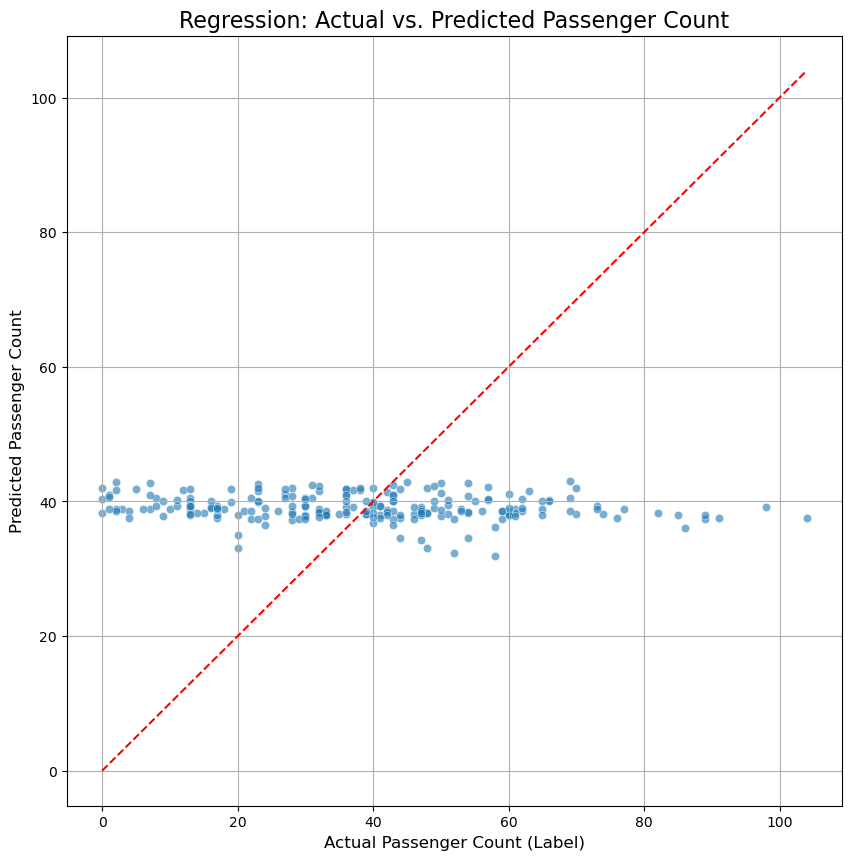

In [5]:
# Run this in your Regression notebook, using the 'gbt_predictions' DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

# A sample is used for plotting to avoid overwhelming the visual
plot_data = gbt_predictions.select("label", "prediction").sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(10, 10))
sns.scatterplot(x='label', y='prediction', data=plot_data, alpha=0.6)

# Add a "perfect prediction" line for reference
plt.plot([plot_data['label'].min(), plot_data['label'].max()], [plot_data['label'].min(), plot_data['label'].max()], 'r--')

# Add titles and labels
plt.title('Regression: Actual vs. Predicted Passenger Count', fontsize=16)
plt.xlabel('Actual Passenger Count (Label)', fontsize=12)
plt.ylabel('Predicted Passenger Count', fontsize=12)
plt.grid(True)
plt.show()

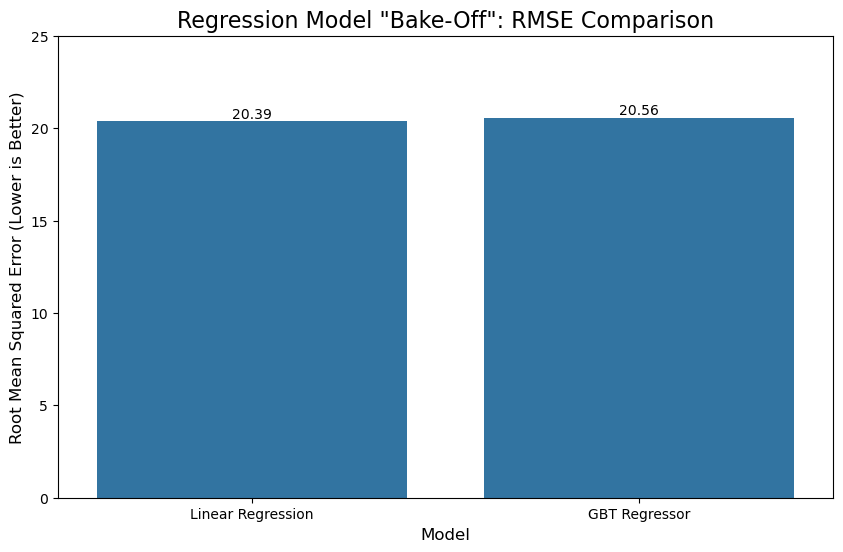

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Manually enter the results from our regression tests
model_results = {
    'Model': ['Linear Regression', 'GBT Regressor'],
    'RMSE': [20.39, 20.56]
}
results_df = pd.DataFrame(model_results)

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_df, x='Model', y='RMSE')

# Add the RMSE values on the bars
ax.bar_label(ax.containers[0], fmt='%.2f')

# Add titles and labels
plt.title('Regression Model "Bake-Off": RMSE Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Root Mean Squared Error (Lower is Better)', fontsize=12)
plt.ylim(0, 25) # Set y-axis limit
plt.show()

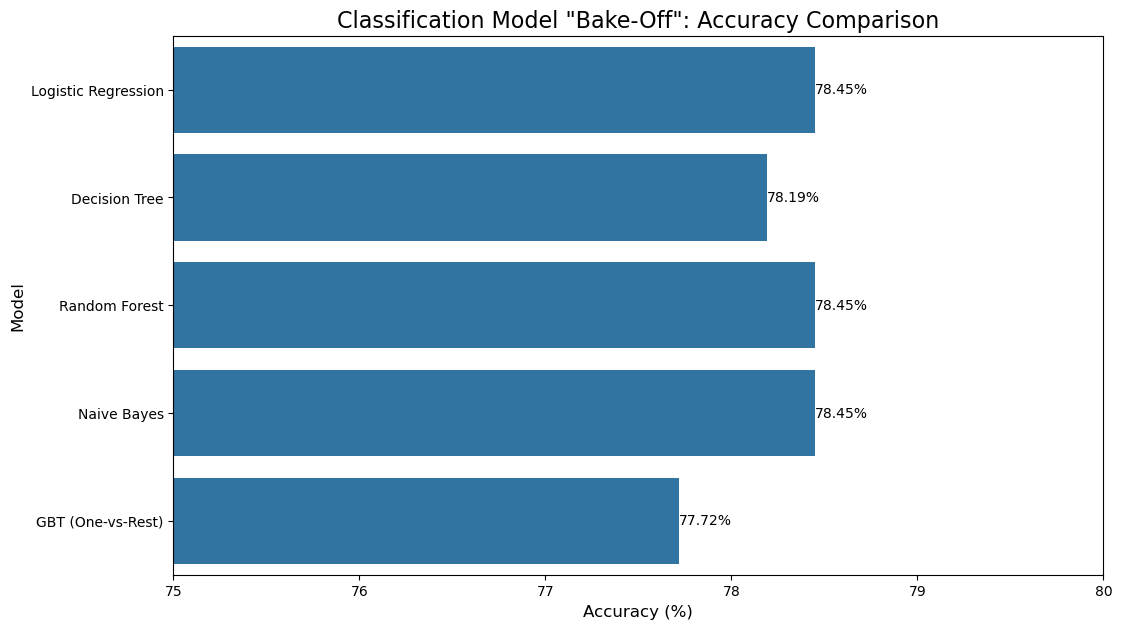

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Manually enter the results from our bake-off
model_results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Naive Bayes', 'GBT (One-vs-Rest)'],
    'Accuracy': [78.45, 78.19, 78.45, 78.45, 77.72]
}
results_df = pd.DataFrame(model_results)

# Create the bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=results_df, x='Accuracy', y='Model')

# Add the accuracy values on the bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f%%')

# Add titles and labels
plt.title('Classification Model "Bake-Off": Accuracy Comparison', fontsize=16)
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(75, 80) # Zoom in on the results for better visibility
plt.show()